<img src="MatchBrand%20symbol.png" alt="MatchBrand Symbol">


# **Topic Modelling with Latent Dirichlet Allocation (LDA)**

After the initial approach using K-means clustering required a significant amount of manual work, we decided to try a different approach for topic modelling - Latent Dirichlet Allocation (LDA) for the following reasons:

* LDA is more interpretable. LDA produces a distribution of words for each topic, which can be used to understand the meaning of the topic. K-means, on the other hand, only produces a cluster label for each document, which can be less informative.

* LDA is more flexible. LDA can be used to model a variety of document corpora, including news articles, scientific papers, and social media posts. K-means is more specialized for clustering numerical data, and it can be less effective for text data.

* LDA is more scalable. LDA can be used to model large document corpora, while K-means can be slow and inefficient for large datasets.

Overall, LDA is a more powerful and flexible topic modeling algorithm than K-means. As our goal when working with MatchBrand is to create an automated and scalable matching process, minimizing manual work would be prioritized. Therefore, the approach with LDA would be recommended to MatchBrand as the final approach. However, it is also important to note that LDA is more computationally expensive and sensitive to hyperparameters. The performance of LDA can vary depending on the hyperparameters that are used. K-means is less sensitive to hyperparameters, and it can be more robust to changes in the data.

The LDA Implementation section is divided into 3 main parts:

* **Topic Modelling: Job Postings**

* **Topic Modelling: Instagram Profiles**

* **Matching Instagram profiles with job postings**

For each dataset, we carried out the following steps:

1. **Find the Optimal Number of Topics**: Similar to the K-means method, an optimal number of topics needs to be determined for the LDA. To accomplish this, we leverage the Coherence Score to evaluate the performance of the LDA models.

    The **Coherence Score** is used to determine the quality of the learned topics. A higher Coherence Score implies that the topic is more meaningful and interpretable.

2. **Labeling**: After determining the optimal number of topics, each topic is labeled using the LDA model's probabilities. The labels are assigned based on the 10 most probable words for each topic, which helps in better interpreting and understanding the latent topics.

    These labels give us a deeper insight into the themes present in our datasets and can be used for further analysis and tasks.

Finally, DistilBERT is used to transform the topics of each dataset into embeddings, and cosine similarity is computed to find the best match between Instagram topics and job topics, just as described in the Topic Modelling with K-Means Clustering.

# Implementation

## A. Load Libraries

In [1]:
''' 
# Install pip packages if not done in alphabetical order to avoid duplicates
!pip install gensim
!pip install torch
!pip install transformers
!pip install scikit-learn
!pip install pyLDAvis
!pip install sentence-transformers
'''

' \n# Install pip packages if not done in alphabetical order to avoid duplicates\n!pip install gensim\n!pip install torch\n!pip install transformers\n!pip install scikit-learn\n!pip install pyLDAvis\n!pip install sentence-transformers\n'

In [2]:
# Import packages in alphabetical order to avoid duplicates
import nltk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyLDAvis.gensim_models

# Import packages in alphabetical order to avoid duplicates
from gensim import corpora, models, similarities
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('wordnet')

c:\Python311\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Python311\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Python311\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Python311\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\timot\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## B. Topic Modelling: Job Postings

For the Job Postings dataset, we attempted to find the optimal number of clusters using the Coherence Score to evaluate different LDA models.

In [3]:
# Load Job Dataset
df_translated_job = pd.read_pickle('Datasets/df_translated_job.pkl')

# Print Job dataset
df_translated_job.head(5)

,Title,Job description,Requirements,Merged
0,apprenticeship as a sales assistant retail cle...,with the knowledge you have acquired you will ...,you have a high school diploma and are interes...,apprenticeship sales assistant retail clerk ed...
1,apprenticeship as a salesperson for the food t...,you will learn how to expertly serve our custo...,you have a high school diploma and you are awa...,apprenticeship salesperson food trade bakery e...
2,apprenticeship as a specialist salesperson for...,we will teach you how to properly process care...,you have a high school diploma and you are awa...,apprenticeship specialist salesperson food tra...
3,integrated retail specialist training edeka markt,you plan and organize the sale you procure goo...,higher education entrance qualification is a p...,integrated retail specialist training edeka ma...
4,sales assistant cashier edeka treugut,they advise and serve our customers and also s...,a completed apprenticeship in retail eg retail...,sales assistant cashier edeka treugut advise s...


### Find the Optimal Number of Topics

After evaluation LDA models with different number of topics ranging from 2 to 12 on the job dataset, the model with 9 topics yielded the highest coherence score. In LDA, Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. However, there are a few things to consider:

* **Dataset size**: Job Dataset only consists of 16 datapoints (16 job postings). Choosing 9 topics may lead to overfitting, which could make our model perform poorly on unseen data. 

* **Interpretability**: In a real-world scenario, the interpretability of the topics is extremely improtant. A model with fewer topics might yield broader themes that are more useful and business-interpretable.

Arguably, we decided to choose 4 topics after trials and errors. The decision is based on achieving a balance between having a reasonable Coherence Score and avoiding overfitting while ensuring the interpretability of the topics. Also, choosing the same number of topics / clusters makes it easier for us to compare with the k-means approach. 

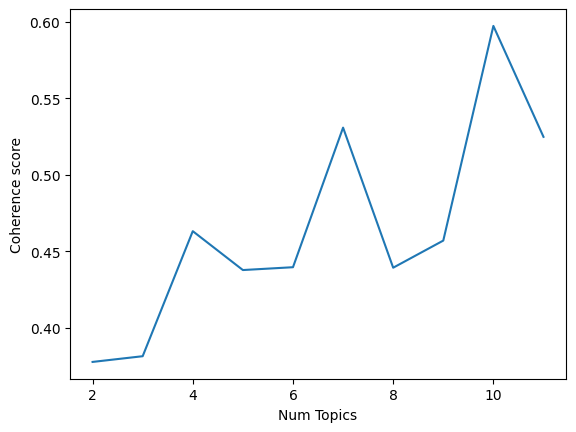

In [4]:
# Evaluation of LDA model

# Tokenize and lemmatize the captions
processed_captions = df_translated_job['Merged'].map(lambda x: [WordNetLemmatizer().lemmatize(w) for w in simple_preprocess(x) if w not in STOPWORDS])

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(processed_captions)

# Convert document into the bag-of-words (BoW) format
corpus = [dictionary.doc2bow(caption) for caption in processed_captions]

# Create an LDA model and find optimal number of topics using coherence score
coherence_values = []
model_list = []
for num_topics in range(2, 12, 1):
    model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, chunksize=100, passes=10)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=processed_captions, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

# Show graph of coherence values for different number of topics
x = range(2, 12, 1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

# Choose the model with the highest coherence score
optimal_model = model_list[coherence_values.index(max(coherence_values))]
optimal_num_topics = x[coherence_values.index(max(coherence_values))]

# Assign each document to a topic (cluster) and get the probabilities
df_translated_job['cluster_distribution'] = [optimal_model[c] for c in corpus]

# Create a dictionary with topics as keys and most probable words as values
topics_dict = {}
for idx in range(optimal_num_topics):
    topics_dict[idx] = [word for word, _ in optimal_model.show_topic(idx, topn=10)]

# Create a new 'topic' column where each row is filled with the words from its assigned topic
df_translated_job['job_topic'] = df_translated_job['cluster_distribution'].apply(lambda x: max(x, key=lambda item: item[1])[0]).map(topics_dict)

In [5]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, dictionary)
pyLDAvis.display(vis)

C:\Users\timot\AppData\Roaming\Python\Python311\site-packages\pandas\core\dtypes\cast.py:1429: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


The LDA model is built with 4 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

In [6]:
# Tokenize and lemmatize the captions
processed_captions = df_translated_job['Merged'].map(lambda x: [WordNetLemmatizer().lemmatize(w) for w in simple_preprocess(x) if w not in STOPWORDS])

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(processed_captions)

# Convert document into the bag-of-words (BoW) format
corpus = [dictionary.doc2bow(caption) for caption in processed_captions]

# Create an LDA model with 4 topics (clusters)
job_lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=4, random_state= 42, chunksize=100, passes=10) #RETHINK IF ITERATION NEEDED!!!!!

# Assign each document to a topic (cluster) and get the probabilities
df_translated_job['cluster_distribution'] = [job_lda_model[c] for c in corpus]

# Assign each document to the topic (cluster) with the highest probability
df_translated_job['cluster'] = df_translated_job['cluster_distribution'].apply(lambda x: max(x, key=lambda item: item[1])[0])

Unlike K-Means, we want to avoid the manual labeling as it is time-comsuming. Therefore, we leverage the probabilistic charateristic of LDA and use the most 10 probable words of each topic to label the topic itself. Now, the text data of Job postings dataset are grouped into 4 topics, whereas each topic is represented by its 10 most probable words.

In [7]:
# Create a dictionary with topics as keys and most probable words as values (top 10 words)
topics_dict = {}
for idx in range(4):
    topics_dict[idx] = [word for word, _ in job_lda_model.show_topic(idx, topn=10)]

# Create a new 'topic' column where each row is filled with the words from its assigned topic
df_translated_job['job_topic'] = df_translated_job['cluster'].apply(lambda x: ' '.join(topics_dict[x]))

## C. Topic Modelling: Instagram Profiles

For the Instagram dataset, we followed a similar approach to the one we used for job postings, utilizing the Coherence Score to evaluate the performance of the LDA models.

In [8]:
# Import insta_no_tokenization (no grouping)
df_translated_insta = pd.read_pickle('Datasets/df_translated_instagram.pkl')

# Print instagram dataset
df_translated_insta.head(10)

,caption,ownerId,ownerUsername
0,roasted garlic butter butter garlic butter foo...,195942622,may jolina
2,neon,195942622,may jolina
4,reconstructive behaviour avoid pain knowing ba...,195942622,may jolina
6,cyprus,201993634,karlikartell
7,cyprus,201993634,karlikartell
8,black quinoa salad pesto zucchini tomato avoca...,195942622,may jolina
9,messing timelines since mid first part october...,1272084402,nele.tuech
10,blinding lights,195942622,may jolina
11,dancing body dance beats,195942622,may jolina
12,thank bibi amazing night,201993634,karlikartell


Like the Job Postings dataset, the LDA model for Instagram profile dataset is also evaluated using the Coherence Score to find the most optimal number of topics. 

Analyzing the coherence graph, we found several viable options for the number of topics. Finally, we decided to choose **10 topics** for the LDA model for the Instagram dataset as it yields the best Coherence Score.

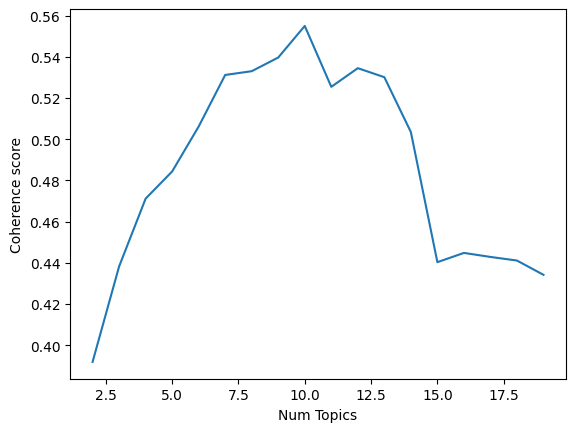

In [9]:
# Evaluation of LDA model
# Tokenize and lemmatize the captions
processed_captions = df_translated_insta['caption'].map(lambda x: [WordNetLemmatizer().lemmatize(w) for w in simple_preprocess(x) if w not in STOPWORDS])

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(processed_captions)

# Convert document into the bag-of-words (BoW) format
corpus = [dictionary.doc2bow(caption) for caption in processed_captions]

# Create an LDA model and find optimal number of topics using coherence score
coherence_values = []
model_list = []
for num_topics in range(2, 20, 1):
    model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, chunksize=100, passes=10)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=processed_captions, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

# Show graph of coherence values for different number of topics
x = range(2, 20, 1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

# Choose the model with the highest coherence score
optimal_model = model_list[coherence_values.index(max(coherence_values))]
optimal_num_topics = x[coherence_values.index(max(coherence_values))]

# Assign each document to a topic (cluster) and get the probabilities
df_translated_insta['cluster_distribution'] = [optimal_model[c] for c in corpus]

# Create a dictionary with topics as keys and most probable words as values
topics_dict = {}
for idx in range(optimal_num_topics):
    topics_dict[idx] = [word for word, _ in optimal_model.show_topic(idx, topn=10)]

# Create a new 'topic' column where each row is filled with the words from its assigned topic
df_translated_insta['insta_topic'] = df_translated_insta['cluster_distribution'].apply(lambda x: max(x, key=lambda item: item[1])[0]).map(topics_dict)

In [10]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, dictionary)
pyLDAvis.display(vis)

C:\Users\timot\AppData\Roaming\Python\Python311\site-packages\pandas\core\dtypes\cast.py:1429: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


The LDA model is built with 10 different topics.

In [11]:
# Tokenize and lemmatize the captions
processed_captions = df_translated_insta['caption'].map(lambda x: [WordNetLemmatizer().lemmatize(w) for w in simple_preprocess(x) if w not in STOPWORDS])

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(processed_captions)

# Convert document into the bag-of-words (BoW) format
corpus = [dictionary.doc2bow(caption) for caption in processed_captions]

# Create an LDA model with 10 topics (clusters)
insta_lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, random_state= 42, chunksize=100, passes=10)

# Assign each document to a topic (cluster) and get the probabilities
df_translated_insta['cluster_distribution'] = [insta_lda_model[c] for c in corpus]

# Assign each document to the topic (cluster) with the highest probability
df_translated_insta['cluster'] = df_translated_insta['cluster_distribution'].apply(lambda x: max(x, key=lambda item: item[1])[0])

After determining the optimal number of topics, each topic is labeled using the LDA model's probabilities. The labels are assigned based on the 10 most probable words for each topic, which helps in better interpreting and understanding the latent topics.

In [12]:
# Create a dictionary with topics as keys and most probable words as values
topics_dict = {}
for idx in range(10):
    topics_dict[idx] = [word for word, _ in insta_lda_model.show_topic(idx, topn=10)]

# Create a new 'topic' column where each row is filled with the words from its assigned topic
df_translated_insta['insta_topic'] = df_translated_insta['cluster'].apply(lambda x: ' '.join(topics_dict[x]))

To offer a more intuitive understanding and gain a better evaluation of the quality of these topics, we examined their **WordClouds**.

C:\Users\timot\AppData\Roaming\Python\Python311\site-packages\pandas\core\dtypes\cast.py:1429: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


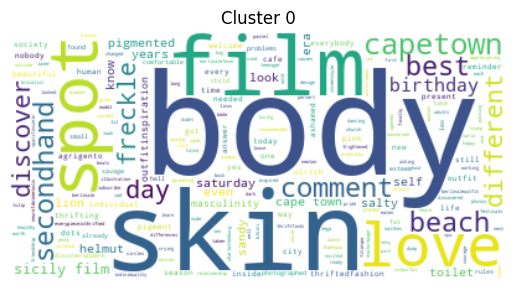

c:\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


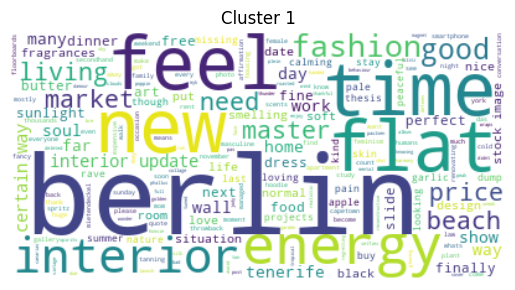

c:\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


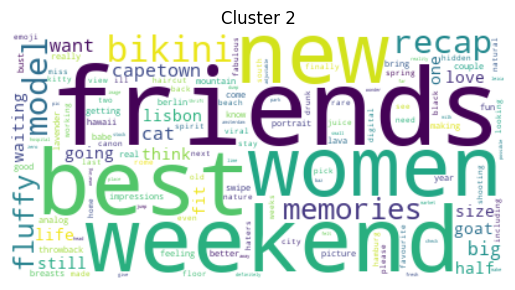

c:\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


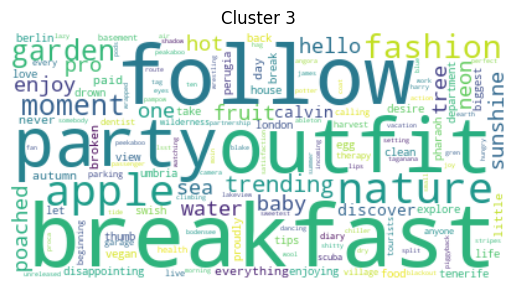

c:\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


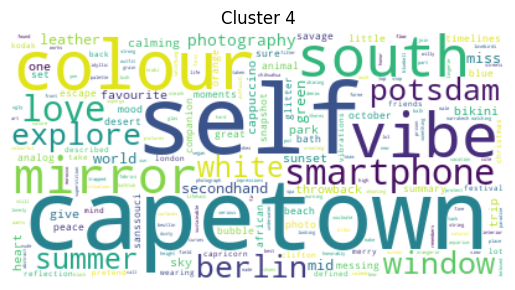

c:\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


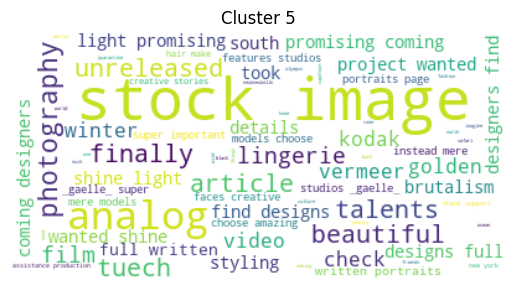

c:\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


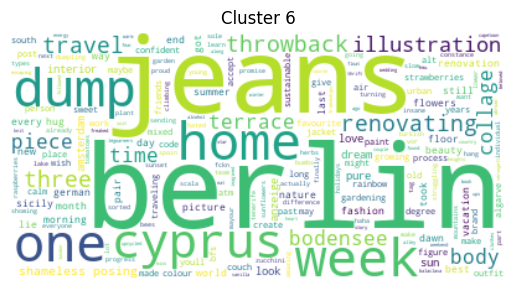

c:\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


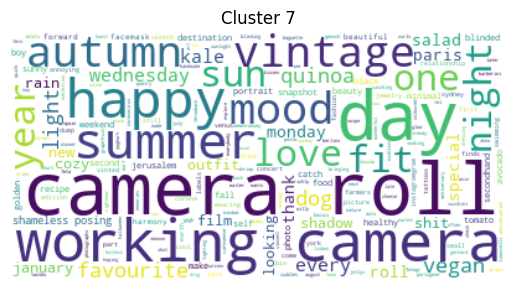

c:\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


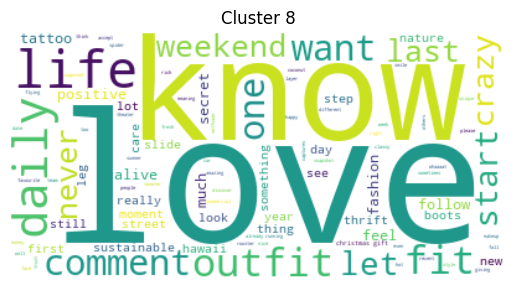

c:\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


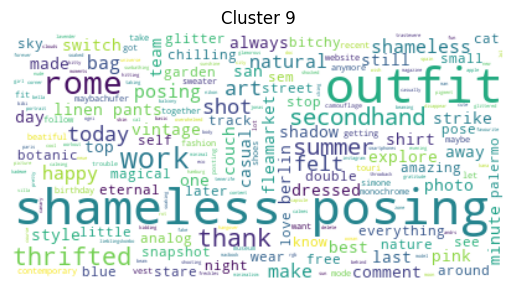

In [13]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# Group the captions by cluster
grouped_captions = df_translated_insta.groupby('cluster')['caption'].apply(' '.join).reset_index()

for i, group in grouped_captions.iterrows():
    # Generate word cloud
    wordcloud = WordCloud(background_color='white').generate(group['caption'])
    
    # Display the word cloud
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {group["cluster"]}')
    plt.show()

## D. Matching Instagram Profiles with Job Postings


Similar with the k-means approach, we leveraged cosine similarity to be the main factor in the matching score.

### Data Preparation

In [14]:
# Group by 'label' and 'ownerUsername' and count posts
df_counts = df_translated_insta.groupby(['insta_topic', 'ownerUsername']).size().reset_index(name='counts')

# Sort by 'label' and 'counts'
df_sorted = df_counts.sort_values(['insta_topic', 'counts'], ascending=[True, False])

# Group by 'label' and join 'ownerUsername' into one cell (preserving order)
df_grouped = df_sorted.groupby('insta_topic')['ownerUsername'].apply(', '.join).reset_index()

# For each unique label in the sorted DataFrame
for label in df_grouped['insta_topic'].unique():
    print(f'{label}:')
    
    # Filter DataFrame for current label
    df_label = df_sorted[df_sorted['insta_topic'] == label]
    
    # Enumerate over rows in filtered DataFrame, adding 1 to index for 1-based numbering
    for i, row in enumerate(df_label.itertuples(), 1):
        print(f'{i}. {row.ownerUsername}, {row.counts}')
        
    print('\n')

berlin new fashion york feel way time flat good interior:
1. karlikartell, 25
2. may jolina, 25
3. nele.tuech, 10
4. stones, 9
5. jonas.ju, 8
6. toxicorny, 3


capetown bikini self explore wearing photo south vibe leather looking:
1. may jolina, 28
2. stones, 19
3. toxicorny, 8
4. karlikartell, 7
5. jonas.ju, 6
6. nele.tuech, 6
7. johannarhr, 1


film body comment beach size discover cheap best birthday guggenheim:
1. may jolina, 20
2. karlikartell, 15
3. stones, 7
4. nele.tuech, 6
5. jonas.ju, 2
6. toxicorny, 2


follow breakfast thumb hot water possible trending garden house nature:
1. jonas.ju, 41
2. stones, 22
3. toxicorny, 18
4. may jolina, 17
5. karlikartell, 16
6. nele.tuech, 6


friend new woman working best going big model making think:
1. karlikartell, 23
2. stones, 16
3. may jolina, 13
4. jonas.ju, 9
5. nele.tuech, 9
6. toxicorny, 6
7. bumble_de, 1


life love want like know style look lot daily different:
1. karlikartell, 21
2. may jolina, 18
3. stones, 13
4. jonas.ju, 12
5

In [15]:
# Group by 'label' and 'ownerUsername' and count posts
df_counts = df_translated_insta.groupby(['insta_topic', 'ownerUsername']).size().reset_index(name='counts')

# Sort by 'label' and 'counts'
df_sorted = df_counts.sort_values(['insta_topic', 'counts'], ascending=[True, False])

# Group by 'label' and join 'ownerUsername' into one cell (preserving order)
df_grouped = df_sorted.groupby('insta_topic')['ownerUsername'].apply(', '.join).reset_index()

data = []

for _, row in df_grouped.iterrows():
    insta_topic = row['insta_topic']
    usernames = row['ownerUsername'].split(', ')
    
    for username in usernames:
        influencer_posts = df_translated_insta[(df_translated_insta['insta_topic'] == insta_topic) & (df_translated_insta['ownerUsername'] == username)]
        posts_text = influencer_posts['caption'].tolist()
        
        merged_posts_text = ' '.join(posts_text)  # join all the captions into one string
        num_captions = len(posts_text)  # count the number of captions

        # append the information to the data list
        data.append({
            'insta_topic': insta_topic,
            'username': username,
            'merged_text': merged_posts_text,
            'num_captions': num_captions
        })

# convert the data list into a DataFrame
df_insta_topic = pd.DataFrame(data)
df_insta_topic.head(10)

,insta_topic,username,merged_text,num_captions
0,berlin new fashion york feel way time flat goo...,karlikartell,days full good food pale skin selfies pale mas...,25
1,berlin new fashion york feel way time flat goo...,may jolina,roasted garlic butter butter garlic butter foo...,25
2,berlin new fashion york feel way time flat goo...,nele.tuech,finally sun berlin berlin berlin interior plan...,10
3,berlin new fashion york feel way time flat goo...,stones,peaceful calming peaceful calming nature apple...,9
4,berlin new fashion york feel way time flat goo...,jonas.ju,fine fine fine feel spring amazing night nice ...,8
5,berlin new fashion york feel way time flat goo...,toxicorny,tropical rave fashion berlin malai cold,3
6,capetown bikini self explore wearing photo sou...,may jolina,shining savage world peace desert capetown ana...,28
7,capetown bikini self explore wearing photo sou...,stones,summary moments calmed moments calming autumn ...,19
8,capetown bikini self explore wearing photo sou...,toxicorny,honorably idyllic photograph white male white ...,8
9,capetown bikini self explore wearing photo sou...,karlikartell,self described self defined explore postcard v...,7


### Matching
 The matching will be conducted between the job topics and instagram topics (which contains the influencers)

In [16]:
# Load original Job postings data from Excel file
df_job =  pd.read_excel('Datasets/dataset_hwr_job_posting.xlsx')

In [17]:
# Use DistilBERT model
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

# Compute embeddings for Instagram Labels and Job labels (Matching the topics)
insta_embeddings = model.encode(df_grouped['insta_topic'].tolist())
job_embeddings = model.encode(df_translated_job['job_topic'].tolist())

# Compute cosine similarity
cosine_similarities = cosine_similarity(insta_embeddings, job_embeddings)

# Get the indices of the most similar job labels for each Instagram caption
most_similar_indices = np.argmax(cosine_similarities, axis=1)

# Get the most similar job labels
most_similar_labels = df_translated_job['job_topic'].iloc[most_similar_indices]

# Add the most similar job labels to your Instagram data
df_grouped['job_topic'] = most_similar_labels.values

In [18]:
# Merge the Instagram and Job data
df_merged = df_grouped.merge(df_translated_job, on='job_topic', how='inner')
df_matching = pd.DataFrame()
df_matching['Company'] = df_job['Company']
df_matching['Job Title DE'] = df_job['Title']
df_matching['Instagram Account'] = df_merged['ownerUsername']
df_matching['Instagram Topic'] = df_merged['insta_topic']

C:\Users\timot\AppData\Roaming\Python\Python311\site-packages\pandas\core\dtypes\cast.py:1429: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [19]:
# First, create a new dataframe where each row corresponds to an unique user
user_post_counts = df_insta_topic.groupby(['username', 'insta_topic'])['num_captions'].sum().reset_index()

# rename 'num_captions' column to 'number_of_posts'
user_post_counts = user_post_counts.rename(columns={'num_captions': 'number_of_posts'})

# 'Instagram Account' in df_final_matching is a string of usernames separated by comma
# So, we need to split this column into a list of usernames

# Split 'Instagram Account' into a list of accounts
df_matching['Instagram Account'] = df_matching['Instagram Account'].str.split(', ')

# Now let's explode 'Instagram Account' so that each row corresponds to a unique account and job title
df_matching = df_matching.explode('Instagram Account')

# Now, merge df_final_matching with user_post_counts
df_matching = pd.merge(df_matching, user_post_counts, how='left', 
                             left_on=['Instagram Account', 'Instagram Topic'], 
                             right_on=['username', 'insta_topic'])

df_matching.head()

,Company,Job Title DE,Instagram Account,Instagram Topic,username,insta_topic,number_of_posts
0,Edeka,Ausbildung Verkäuferin (m/w/d) / Kauffrau im E...,karlikartell,berlin new fashion york feel way time flat goo...,karlikartell,berlin new fashion york feel way time flat goo...,25
1,Edeka,Ausbildung Verkäuferin (m/w/d) / Kauffrau im E...,may jolina,berlin new fashion york feel way time flat goo...,may jolina,berlin new fashion york feel way time flat goo...,25
2,Edeka,Ausbildung Verkäuferin (m/w/d) / Kauffrau im E...,nele.tuech,berlin new fashion york feel way time flat goo...,nele.tuech,berlin new fashion york feel way time flat goo...,10
3,Edeka,Ausbildung Verkäuferin (m/w/d) / Kauffrau im E...,stones,berlin new fashion york feel way time flat goo...,stones,berlin new fashion york feel way time flat goo...,9
4,Edeka,Ausbildung Verkäuferin (m/w/d) / Kauffrau im E...,jonas.ju,berlin new fashion york feel way time flat goo...,jonas.ju,berlin new fashion york feel way time flat goo...,8


In [20]:
# Group by 'Job Title DE' and 'Instagram Topic', 
# then aggregate 'Instagram Account' and 'number_of_posts' into comma-separated strings
df_final_matching = df_matching.groupby(['Company', 'Job Title DE', 'Instagram Topic']).agg({
    'Instagram Account': ', '.join,
    'number_of_posts': lambda x: ', '.join(map(str, x))
}).reset_index()

# Merge the two DataFrames on the relevant columns
df_final = pd.merge(df_final_matching, df_insta_topic,  how='left', left_on=['Instagram Account','Job Title DE'], right_on = ['username','insta_topic'])

# Resuse pickle files
job_postings_vectors_bert = pd.read_pickle("Datasets/bert_job_postings_vectors.pkl")
instagram_postings_vectors_bert = pd.read_pickle("Datasets/bert_instagram_postings_vectors.pkl")

# Compute cosine similarity
cosine_similarities = cosine_similarity(job_postings_vectors_bert, instagram_postings_vectors_bert)

matching_scores = np.max(cosine_similarities, axis=1)

# Add the matching score to the DataFrame
df_final['topic_matching_score'] = matching_scores

### Matching Results

The **total_score** consists of two parts. The first part consists of the multiplication between the topic_matching_score and defined weight of 0.9.
The second part is composed of the multiplication between the proportion_of_posts and the defined weight of 0.1, where

* **topic_matching_score** == the result of the cosine similarity between the instagram and job topics with values ranging between -1 and 1. The value "1" represents the perfect similarity, while "-1" is the worst one.

* **proportion_of_posts** == the ratio of the number of posts by a specific influencer on a particular topic to the total number of posts on the same topic by all influencers.

The closer the score to 1 the better is the match.

In practice, this matching score can be improved significantly by incorporating real world outcomes (e.g. if candidates really apply for the jobs or even if they get hired in the end) in the dataset to improve and evaluate the model predictions.

In [21]:
df_final = df_final.drop(['insta_topic', 'username', 'merged_text', 'num_captions'], axis=1)

# Split the 'number_of_posts' column by comma delimiter and convert the values to a list
df_final['number_of_posts'] = df_final['number_of_posts'].str.split(',')

# Convert the 'topic_matching_score' column to numeric
df_final['topic_matching_score'] = pd.to_numeric(df_final['topic_matching_score'])

# Convert the 'number_of_posts' list to integers
df_final['number_of_posts'] = df_final['number_of_posts'].apply(lambda x: list(map(int, x)))

# Calculate the total number of posts for each job
df_final['total_posts'] = df_final['number_of_posts'].apply(sum)

# Compute the proportion of posts per job
df_final['proportion_of_posts'] = df_final.apply(lambda row: [post/row['total_posts'] for post in row['number_of_posts']], axis=1)

# Define weights
weight_proportion_of_posts = 0.1
weight_topic_matching_score = 0.9

# Calculate total score using the proportion of posts and topic_matching_score
df_final['total_score'] = df_final.apply(lambda row: [round(row['topic_matching_score'] * weight_topic_matching_score + weight_proportion_of_posts * proportion, 2) for proportion in row['proportion_of_posts']], axis=1)

# Round the values in the 'topic_matching_score' and 'proportion_of_posts' columns to 2 decimal places
df_final['topic_matching_score'] = df_final['topic_matching_score'].apply(lambda x: round(x, 2))
df_final['proportion_of_posts'] = df_final['proportion_of_posts'].apply(lambda x: [round(proportion, 2) for proportion in x])

df_final

C:\Users\timot\AppData\Roaming\Python\Python311\site-packages\pandas\core\dtypes\cast.py:1429: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\timot\AppData\Roaming\Python\Python311\site-packages\pandas\core\dtypes\cast.py:1429: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\timot\AppData\Roaming\Python\Python311\site-packages\pandas\core\dtypes\cast.py:1429: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more info

,Company,Job Title DE,Instagram Topic,Instagram Account,number_of_posts,topic_matching_score,total_posts,proportion_of_posts,total_score
0,Bosch,Developer for Embedded Linux (f/m/div.),life love want like know style look lot daily ...,"karlikartell, may jolina, stones, jonas.ju, to...","[21, 18, 13, 12, 6, 4]",0.88,74,"[0.28, 0.24, 0.18, 0.16, 0.08, 0.05]","[0.82, 0.82, 0.81, 0.81, 0.8, 0.8]"
1,Buying Labs GmbH,Werkstudent/in Buying (m/w/d) Luxury / Premium...,life love want like know style look lot daily ...,"karlikartell, may jolina, stones, jonas.ju, to...","[21, 18, 13, 12, 6, 4]",0.90,74,"[0.28, 0.24, 0.18, 0.16, 0.08, 0.05]","[0.84, 0.83, 0.83, 0.83, 0.82, 0.81]"
2,Edeka,Ausbildung Fachverkäuferin Lebensmittelhandwer...,berlin new fashion york feel way time flat goo...,"karlikartell, may jolina, nele.tuech, stones, ...","[25, 25, 10, 9, 8, 3]",0.90,80,"[0.31, 0.31, 0.12, 0.11, 0.1, 0.04]","[0.84, 0.84, 0.83, 0.82, 0.82, 0.82]"
3,Edeka,Ausbildung Fachverkäuferin Lebensmittelhandwer...,berlin new fashion york feel way time flat goo...,"karlikartell, may jolina, nele.tuech, stones, ...","[25, 25, 10, 9, 8, 3]",0.86,80,"[0.31, 0.31, 0.12, 0.11, 0.1, 0.04]","[0.8, 0.8, 0.79, 0.78, 0.78, 0.78]"
4,Edeka,Ausbildung Handelsfachwirtin integriert (m/w/d...,berlin new fashion york feel way time flat goo...,"karlikartell, may jolina, nele.tuech, stones, ...","[25, 25, 10, 9, 8, 3]",0.92,80,"[0.31, 0.31, 0.12, 0.11, 0.1, 0.04]","[0.86, 0.86, 0.84, 0.84, 0.84, 0.83]"
5,Edeka,Ausbildung Verkäuferin (m/w/d) / Kauffrau im E...,berlin new fashion york feel way time flat goo...,"karlikartell, may jolina, nele.tuech, stones, ...","[25, 25, 10, 9, 8, 3]",0.92,80,"[0.31, 0.31, 0.12, 0.11, 0.1, 0.04]","[0.86, 0.86, 0.84, 0.84, 0.84, 0.83]"
6,Edeka,Backwaren-Liebhaberin (m/w/d),friend new woman working best going big model ...,"karlikartell, stones, may jolina, jonas.ju, ne...","[23, 16, 13, 9, 9, 6, 1]",0.90,77,"[0.3, 0.21, 0.17, 0.12, 0.12, 0.08, 0.01]","[0.84, 0.83, 0.83, 0.82, 0.82, 0.82, 0.81]"
7,Edeka,Stellvertretende Marktleitung (m/w/d) EDEKA Ci...,friend new woman working best going big model ...,"karlikartell, stones, may jolina, jonas.ju, ne...","[23, 16, 13, 9, 9, 6, 1]",0.85,77,"[0.3, 0.21, 0.17, 0.12, 0.12, 0.08, 0.01]","[0.79, 0.79, 0.78, 0.78, 0.78, 0.77, 0.77]"
8,Edeka,Verkäuferin / Kassiererin (m/w/d) EDEKA Treugut,friend new woman working best going big model ...,"karlikartell, stones, may jolina, jonas.ju, ne...","[23, 16, 13, 9, 9, 6, 1]",0.86,77,"[0.3, 0.21, 0.17, 0.12, 0.12, 0.08, 0.01]","[0.81, 0.8, 0.8, 0.79, 0.79, 0.79, 0.78]"
9,Ernsting’s family,Trainee Fashion Management,capetown bikini self explore wearing photo sou...,"may jolina, stones, toxicorny, karlikartell, j...","[28, 19, 8, 7, 6, 6, 1]",0.88,75,"[0.37, 0.25, 0.11, 0.09, 0.08, 0.08, 0.01]","[0.83, 0.82, 0.8, 0.8, 0.8, 0.8, 0.79]"


In [22]:
# Convert 'Instagram Account', 'number_of_posts', 'proportion_of_posts', and 'total_score' from string back to list
df_final['Instagram Account'] = df_final['Instagram Account'].astype(str).str.split(', ')
df_final['number_of_posts'] = df_final['number_of_posts'].apply(lambda x: [int(i) for i in x])
df_final['proportion_of_posts'] = df_final['proportion_of_posts'].apply(lambda x: [float(i) for i in x])
df_final['total_score'] = df_final['total_score'].apply(lambda x: [float(i) for i in x])

# Create an empty DataFrame
df_final_expanded = pd.DataFrame()

# Loop through each row of df_final
for idx, row in df_final.iterrows():
    # Get the first 3 Instagram Accounts, number_of_posts, proportion_of_posts and total_score
    for i in range(3):
        try:
            instagram_account = row['Instagram Account'][i]
            number_of_posts = row['number_of_posts'][i]
            proportion_of_posts = row['proportion_of_posts'][i]
            total_score = row['total_score'][i]
            
            # Append this data to the new DataFrame
            new_row = pd.DataFrame({
                'Company': [row['Company']],
                'Job Title DE': [row['Job Title DE']],
                'Instagram Topic': [row['Instagram Topic']],
                'Instagram Account': [instagram_account],
                'number_of_posts': [number_of_posts],
                'topic_matching_score': [row['topic_matching_score']],
                'total_posts': [row['total_posts']],
                'proportion_of_posts': [proportion_of_posts],
                'total_score': [total_score]
            })
            
            df_final_expanded = pd.concat([df_final_expanded, new_row], ignore_index=True)
        except IndexError:
            # This handles cases where there are less than 3 Instagram accounts for a job
            continue

C:\Users\timot\AppData\Roaming\Python\Python311\site-packages\pandas\core\dtypes\cast.py:1429: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [23]:
# Print all available job titles
print(df_final_expanded['Job Title DE'].unique())

['Developer for Embedded Linux (f/m/div.)'
 'Werkstudent/in Buying (m/w/d) Luxury / Premium Fashion'
 'Ausbildung Fachverkäuferin Lebensmittelhandwerk - Bäckerei (m/w/d) EDEKA Center - 2023'
 'Ausbildung Fachverkäuferin Lebensmittelhandwerk - Fleischerei (m/w/d) EDEKA Markt - 2023'
 'Ausbildung Handelsfachwirtin integriert (m/w/d) EDEKA Markt - 2023'
 'Ausbildung Verkäuferin (m/w/d) / Kauffrau im Einzelhandel (m/w/d) EDEKA Markt - 2023'
 'Backwaren-Liebhaberin (m/w/d)'
 'Stellvertretende Marktleitung (m/w/d) EDEKA City Markt'
 'Verkäuferin / Kassiererin (m/w/d) EDEKA Treugut'
 'Trainee Fashion Management' 'Verkäufer (m/w/d) Modebranche'
 'Software Engineer - Python'
 'Developer MS Dynamics 365 Business Central / NAV (m/w/d)'
 'Senior Python Developer (f/m/d)'
 'Praktikum Merchandising & Produktentwicklung (fashion/apparel)'
 'Fashion Consultant (m/w/d)']


In [24]:
# Print samples of the final results with the top 3 best matches
#df_final_expanded[(df_final_expanded['Job Title DE'] == 'Trainee Fashion Management') | (df_final_expanded['Job Title DE'] == 'Fashion Consultant (m/w/d)')]
df_final_expanded[(df_final_expanded['Job Title DE'] == 'Trainee Fashion Management')]

,Company,Job Title DE,Instagram Topic,Instagram Account,number_of_posts,topic_matching_score,total_posts,proportion_of_posts,total_score
27,Ernsting’s family,Trainee Fashion Management,capetown bikini self explore wearing photo sou...,may jolina,28,0.88,75,0.37,0.83
28,Ernsting’s family,Trainee Fashion Management,capetown bikini self explore wearing photo sou...,stones,19,0.88,75,0.25,0.82
29,Ernsting’s family,Trainee Fashion Management,capetown bikini self explore wearing photo sou...,toxicorny,8,0.88,75,0.11,0.80


As the results, the top 3 Instagram profiles that match with the Job "Trainee Fashion Management" are: "may jolina", "stones" and "toxicorny" as they are grouped in the same Instagram topic. The ranking differs by the proportion of posts on their profile about the said topic. Examining these Instagram profiles, we found that the influencer "may jolina" is indeed the best match with such job posting. Compared with the results of the approach with K-Means, this might demonstrate a similarity between the two models.

## E. Next Steps 

In this section we will give an outlook of possible next steps ragrding our project.

**1.  Optimize Data Cleaning - Customize wordninja language model:**

For data cleaning we used the wordninja library for the instagram data which lead to certain restrictions as the accuracy of this library lacks if the input text conatins domain-specific terms not present in the training data. These limitations/disadvantages can be reduced by customizing the wordninja language model to MatchBrand's needs. With that, the data quality and the analysis accuracy could be further improved. 


**2. Improve calculation of total score:**

Another point for potential improvement is the calculation of the total score. The weights of 10% and 90 % are right now hard coded and result of our opinion of importance proportion. One option could be to collect insights from successful hires in order to get feedback e.g. from HR or survey candidates. This could serve as a basis to improve the calculation/determination of the total matching score. 

Furthermore, more features could be involved for the matching process like locations and follower counts in order to get to the total score. 

**3. Expand matching criteria:**

As mentioned in the introcuction (see README) we focused on one out of three possible matching score approaches. The other two which are matching the social media profiles on job they would directly apply themselves and to match based on followers of the social media profiles with jobs to apply could be explored by MatchBrand in the future. 

**4. Include other methods - image classification & leverage more advanced models:**

Moreover, new methods could be tried it. That includes for example image classification for social media data. 
On the other hand, advanced models like hugging face models specialized on topic classification could be explored to enhance efficiency and to have more robust topics in order to avoid manual labeling in K-means clustering. Another idea would be to use a supervised learning model which is trained on our already discovered models.

**5. Explore new matching approach**

Another next step for MatchBrand could be to explore new matching approaches. For instance, to calculate to different cosine similarities for a) instagram topics and job titles (cosine similarity 1) and b) instagram topics and requirements & location (cosine similarity 2). A new matching formula could look as follows: total score = cosine similarity 1* weight1 + cosine similarity 2* weight2 + proportion of posts per topic * weight3. 